In [2]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
!cp '/content/drive/MyDrive/transformer/dataset.zip' dataset.zip

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import zipfile
with zipfile.ZipFile("dataset.zip", 'r') as zip_ref:
    zip_ref.extractall("./")

In [4]:
full_data = pd.read_csv('/content/training.1600000.processed.noemoticon.csv',
                        encoding='latin-1').drop(["1467810369",
                                                  "Mon Apr 06 22:19:45 PDT 2009",
                                                  "NO_QUERY","_TheSpecialOne_"],
                                                 axis=1).dropna()
columns_names = list(full_data)
full_data.rename(columns={columns_names[0]:"label",
                        columns_names[1]:"text"}, inplace= True)

In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

In [6]:
# Chuyển nhãn 4 thành 1 (để có 0: Negative, 1: Positive)
full_data['label'] = full_data['label'].replace(4, 1)

# Lấy text và target`
texts = full_data['text'].values
labels = full_data['label'].values

# Chia tập train/test
train_texts, val_texts, train_labels, val_labels = train_test_split(
    texts, labels, test_size=0.2, random_state=42
)

In [7]:
import tensorflow as tf

# Tạo tf.data.Dataset từ numpy arrays
train_ds = tf.data.Dataset.from_tensor_slices((train_texts, train_labels))
val_ds = tf.data.Dataset.from_tensor_slices((val_texts, val_labels))


In [8]:
batch_size = 1024
train_ds = tf.data.Dataset.from_tensor_slices((train_texts, train_labels))
train_ds = train_ds.shuffle(buffer_size=10000, seed=42).batch(batch_size)
val_ds = val_ds.batch(batch_size)


In [9]:
for text_batch, label_batch in train_ds:
    print(label_batch[0].numpy())
    print(text_batch[0].numpy().decode('ascii'))
    break


1
Even though the chances of TH coming to the Comets are almost non existant, I'm starting to look forward to it 


In [10]:
import io
import re
import string
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Embedding, GlobalAveragePooling1D


In [11]:
vocab_size = 20000
sequence_len = 200
contractions = {
    "im": "i am", "i'm": "i am", "you're": "you are", "youre": "you are",
    "don't": "do not", "cant": "can not", "it's": "it is", "ive": "i have",
    "doesn't": "does not", "didn't": "did not", "wasn't": "was not",
    "they're": "they are", "that's": "that is", "couldn't": "could not"
}

def expand_contractions(text):
    for word, full in contractions.items():
        text = re.sub(r"\b" + word + r"\b", full, text)
    return text

def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    no_html = tf.strings.regex_replace(lowercase, "<br\s*/?>", " ")
    no_url = tf.strings.regex_replace(no_html, r"http\S+|www\S+|https\S+", " ")
    no_mentions = tf.strings.regex_replace(no_url, r"@\w+", " ")
    no_hashtags = tf.strings.regex_replace(no_mentions, r"#\w+", " ")
    no_numbers = tf.strings.regex_replace(no_hashtags, r"\d+", " ")
    no_punct = tf.strings.regex_replace(no_numbers, f"[{re.escape(string.punctuation)}]", " ")
    no_extra_spaces = tf.strings.regex_replace(no_punct, r"\s+", " ")
    return no_extra_spaces
vectorization = tf.keras.layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_len,
)


In [12]:
output = custom_standardization(text_batch[0].numpy().decode('ascii'))
print(output.numpy().decode())

even though the chances of th coming to the comets are almost non existant i m starting to look forward to it 


In [13]:
# B2: Học từ điển từ dữ liệu văn bản
vectorization.adapt(train_ds.map(lambda text, label: text))

# B3: Dùng để vector hóa
def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorization(text), label

# B4: Biến đổi dataset
train_ds = train_ds.map(vectorize_text)
val_ds = val_ds.map(vectorize_text)


In [14]:
for text_batch, label_batch in train_ds:
  print(label_batch[0].numpy())
  print(text_batch[0].numpy())
  break

0
[9806 2160 2160    1    1 7370    1    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    

In [15]:
train_ds = train_ds.cache().prefetch(buffer_size=10)
val_ds = train_ds.cache().prefetch(buffer_size=10)

TRAINING

In [16]:
from tensorflow.keras import layers

class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super().__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)


In [17]:
class TokenAndSinCosPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super().__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.maxlen = maxlen
        self.embed_dim = embed_dim

    def get_angles(self, pos, i, d_model):
        angles = pos / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
        return angles

    def positional_encoding(self, position, d_model):
        angle_rads = self.get_angles(
            np.arange(position)[:, np.newaxis],
            np.arange(d_model)[np.newaxis, :],
            d_model
        )

        angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

        angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

        pos_encoding = angle_rads[np.newaxis, ...]
        return tf.cast(pos_encoding, dtype=tf.float32)

    def call(self, x):
        maxlen = tf.shape(x)[-1]  # lấy độ dài chuỗi hiện tại (batch, seq_len)
        x = self.token_emb(x)

        pos_encoding = self.positional_encoding(self.maxlen, self.embed_dim)
        x += pos_encoding[:, :maxlen, :]
        return x


In [18]:
from tensorflow import keras
embed_dim = 128     # Embedding size
num_heads = 6       # Number of attention heads
ff_dim = 128        # Feedforward layer size

embedding_layer = TokenAndSinCosPositionEmbedding(sequence_len, vocab_size, embed_dim)
inputs = layers.Input(shape=(sequence_len,))
x = embedding_layer(inputs)

transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x, training=True)

x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(32, activation="relu")(x)
x = layers.Dropout(0.1)(x)
outputs = layers.Dense(2, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs)
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ token_and_sin_cos_position_emb… │ (None, 200, 128)       │     2,560,000 │
│ (TokenAndSinCosPositionEmbeddi… │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block               │ (None, 200, 128)       │       429,184 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,993,378 (11.42 MB)

 Trainable params: 2,993,378 (11.42 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

history = model.fit(train_ds,
                    epochs=5,
                    validation_data=val_ds)


Epoch 1/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 729s 569ms/step - accuracy: 0.5431 - loss: 0.6673 - val_accuracy: 0.8086 - val_loss: 0.4155
Epoch 2/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 702s 561ms/step - accuracy: 0.8066 - loss: 0.4218 - val_accuracy: 0.8204 - val_loss: 0.3949
Epoch 3/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 705s 564ms/step - accuracy: 0.8165 - loss: 0.4028 - val_accuracy: 0.8274 - val_loss: 0.3808
Epoch 4/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 707s 565ms/step - accuracy: 0.8234 - loss: 0.3896 - val_accuracy: 0.8330 - val_loss: 0.3703
Epoch 5/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 738s 591ms/step - accuracy: 0.8289 - loss: 0.3791 - val_accuracy: 0.8377 - val_loss: 0.3606


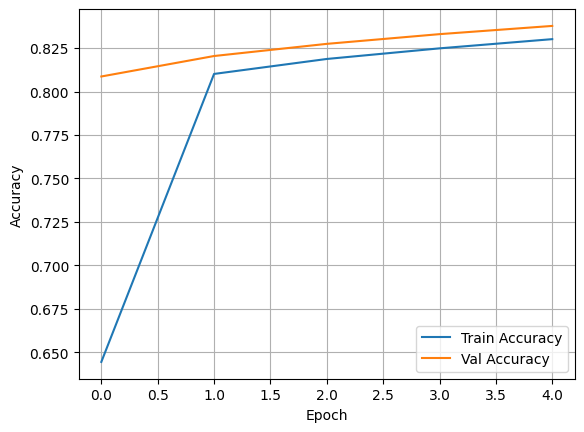

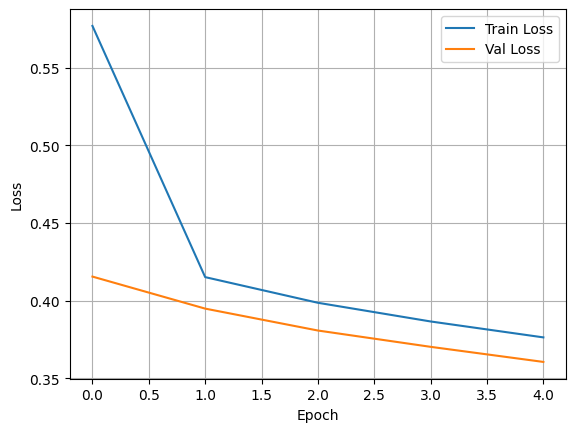

In [20]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()
